## 1) Visualization: 
### Disentangle the wedge and mask it.

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.patches as patches
import scipy
import fitsio
from skimage.transform import downscale_local_mean
import skimage.filters
%matplotlib notebook
#%matplotlib inline

In [2]:
fnm = 'Y4A1_20160801t1215_g_c03_r2930p01_skypca-tmpl.fits'

In [3]:
hdu = fitsio.FITS(fnm)
comp = hdu[0].read()
c0 = comp[0, :, :]

<IPython.core.display.Javascript object>


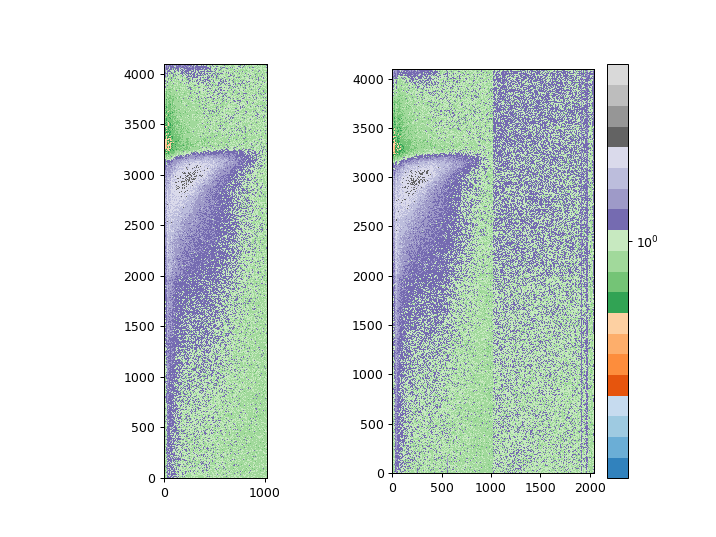

In [4]:
from matplotlib.colors import LogNorm
plt.close('all')
fig, ax = plt.subplots(1, 2, figsize=(8, 6))
# vmed, vstd = np.median(comp[0, :, :]), np.std(comp[0, :, :])
guess_min, guess_max = 0.925, 1.06
aux_dic = {
    'cmap' : 'tab20c', 
    'origin' : 'lower',
    'vmin' : guess_min, 
    'vmax' : guess_max,
    'norm' : LogNorm(), 
}
img1 = ax[0].imshow(c0, **aux_dic)
img2 = ax[1].imshow(c0, **aux_dic)
ax[0].set_xlim([0, 1024])
plt.colorbar(img1)

### Iso lines without previous softening of wedge-surface

In [5]:
d0, d1 = np.arange(c0.shape[0]), np.arange(c0.shape[1])
d0_grid, d1_grid = np.meshgrid(d0, d1, indexing='ij')

In [6]:
print(d0_grid.shape, d1_grid.shape, c0.shape)

(4096, 2048) (4096, 2048) (4096, 2048)


In [7]:
# Mask the PCA component to values close to 1
cond_x0 = np.logical_or(c0 < guess_min, c0 > guess_max)
masked_c0 = np.ma.masked_where(cond_x0, c0)

<IPython.core.display.Javascript object>


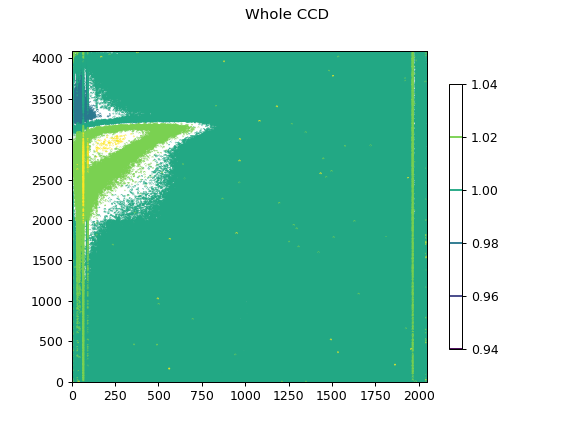

Text(0.5,0.98,'Whole CCD')

In [8]:
plt.close('all')
cs = plt.contour(d1_grid, d0_grid, masked_c0)
cb = plt.colorbar(cs, shrink=0.8, extend='both')
plt.suptitle('Whole CCD')

In [11]:
# Only use left amplifier
c0_left = c0[: , :1024]
cond_x1 = np.logical_or(c0_left < guess_min, c0_left > guess_max)
masked_c0_left = np.ma.masked_where(cond_x1, c0_left)

In [12]:
d0_left, d1_left = np.meshgrid(d0, d1[:1024], indexing='ij')

<IPython.core.display.Javascript object>


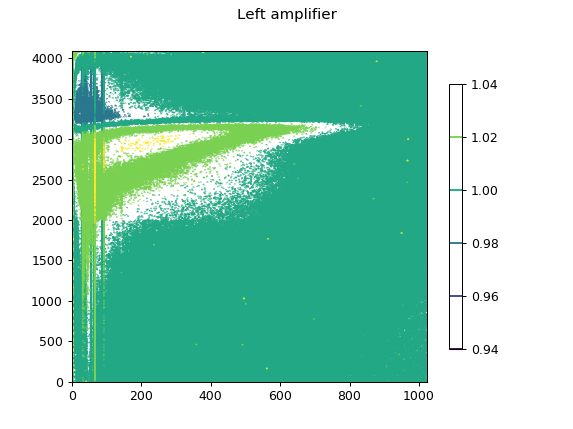

Text(0.5,0.98,'Left amplifier')

In [13]:
plt.close('all')
cs = plt.contour(d1_left, d0_left, masked_c0_left, cmap='viridis')
cb = plt.colorbar(cs, shrink=0.8, extend='both')
plt.suptitle('Left amplifier')

### Assess the behavior of the wedge

### For easier visualization, bin the image

In [14]:
def downsample_2d(M, bin_factor, const_padding=-1):
    ''' Scikit method to bin images. Can be applied to N-dimensional 
    arrays.  Calculates the local mean of each binned block in the 
    input image
    Inputs
    - bin_factor: bin_d0, bin_d1: integers. Bin factor for dimensions 0 and 1
    - const_padding: padding value to be used if image size division
    by bin factors isn't exact
    Returns
    - resized array image
    '''
    bin_d0, bin_d1 = bin_factor
    binned = downscale_local_mean(
        M, 
        (bin_d0, bin_d1), 
        cval=const_padding,
    )
    return binned 

In [15]:
bin_left = downsample_2d(masked_c0_left, (4,4))
bin_d0, bin_d1 = np.arange(bin_left.shape[0]), np.arange(bin_left.shape[1])
bin_d0, bin_d1 = np.meshgrid(bin_d0, bin_d1, indexing='ij')

### Mask binned

In [16]:
cond_x1 = np.logical_or(bin_left < guess_min, bin_left > guess_max)
mask_bin_left = np.ma.masked_where(cond_x1, bin_left)

### After binned, plot in 3D perspective, using proper z-axis limits 

In [17]:
aux_z = np.copy(bin_left)
aux_z[mask_bin_left.mask] = np.nan

### Projections

<IPython.core.display.Javascript object>


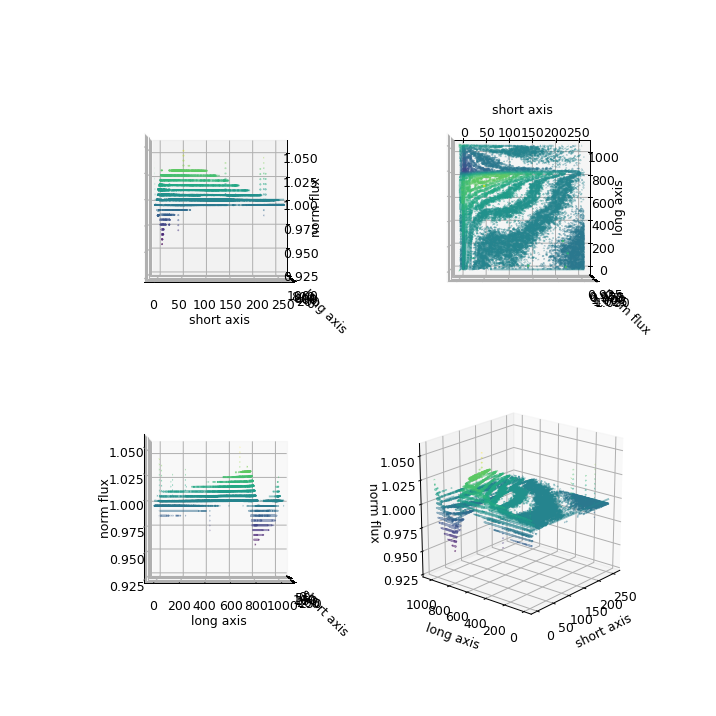

In [18]:
plt.close('all')
fig = plt.figure(figsize=(8, 8))
ax0 = fig.add_subplot(2, 2, 1, projection='3d')
ax1 = fig.add_subplot(2, 2, 2, projection='3d')
ax2 = fig.add_subplot(2, 2, 3, projection='3d')
ax3 = fig.add_subplot(2, 2, 4, projection='3d')
#
ax0.contour3D(bin_d1, bin_d0, aux_z, 20, cmap='viridis', alpha=0.5)
ax0.set_zlim([guess_min, guess_max])
ax0.view_init(0, -90)
ax0.axes.get_yaxis().set_visible(False) # ax0.set_axis_off()
#
ax1.contour3D(bin_d1, bin_d0, aux_z, 20, cmap='viridis', alpha=0.5)
ax1.set_zlim([guess_min, guess_max])
ax1.view_init(90, -90)
ax1.axes.get_yaxis().set_visible(False) # ax0.set_axis_off()
#
ax2.contour3D(bin_d1, bin_d0, aux_z, 20, cmap='viridis', alpha=0.5)
ax2.set_zlim([guess_min, guess_max])
ax2.view_init(0, 0)
ax2.axes.get_yaxis().set_visible(False) # ax0.set_axis_off()
#
cont3d = ax3.contour3D(bin_d1, bin_d0, aux_z, 20, cmap='viridis', alpha=0.5)
ax3.set_zlim([guess_min, guess_max])
ax3.view_init(20, -140)
#
for ax in [ax0, ax1, ax2, ax3]:
    ax.set_xlabel('short axis')
    ax.set_ylabel('long axis')
    ax.set_zlabel('norm flux')


<IPython.core.display.Javascript object>


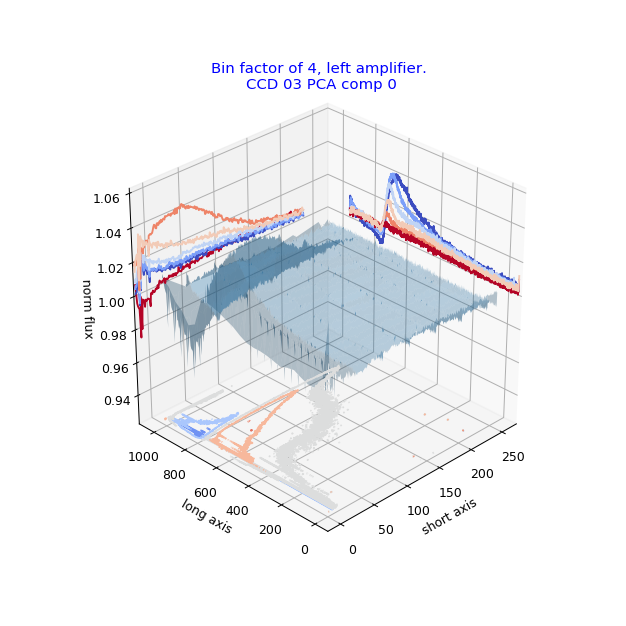

In [16]:
plt.close('all')

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(1, 1, 1, projection='3d')

ax.plot_surface(bin_d1, bin_d0, aux_z, rstride=40, cstride=40, alpha=0.3)
cset = ax.contour(bin_d1, bin_d0, aux_z, zdir='z', offset=guess_min, cmap='coolwarm')
cset = ax.contour(bin_d1, bin_d0, aux_z, zdir='x', offset=290, cmap='coolwarm')
cset = ax.contour(bin_d1, bin_d0, aux_z, zdir='y', offset=1180, cmap='coolwarm')

ax.set_zlim([guess_min, guess_max])
ax.set_xlabel('short axis')
ax.set_ylabel('long axis')
ax.set_zlabel('norm flux')

ax.set_title('Bin factor of 4, left amplifier. \nCCD 03 PCA comp 0\n', color='b')

ax.view_init(30, -135)


### 2) Create the mask
####  Rectangular-based mask, using bits from imsupport : mask_bits.h

In [19]:
# Filter image. Use a Gaussian kernel of sigma=4, same size as 
# the above binning factor
# Assign NaN to masked values
nan_masked_x0 = np.copy(masked_c0)
nan_masked_x0[masked_c0.mask] = np.nan
# Set a Gaussian filter over the array with NaN for out of range values
fgauss_kw = {
    'sigma': 4, 
    'mode': 'nearest',
    'cval': -1,
}
fgauss_x0 = skimage.filters.gaussian(nan_masked_x0, **fgauss_kw)

<IPython.core.display.Javascript object>


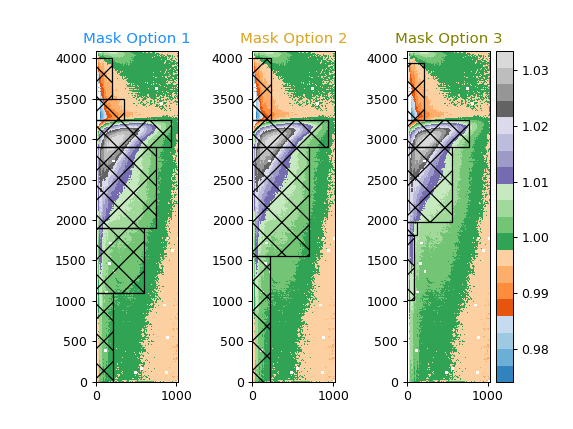

In [20]:
# Create rectangles for left amplifier, first component of PCA
plt.close('all')
fig = plt.figure()
ax0 = fig.add_subplot(1, 3, 1, aspect='equal')
#
# Option 1
im = ax0.imshow(fgauss_x0[:, :1024], cmap='tab20c', origin='lower')
# boxes
w1, h1, ini1 = 220, 1100, (0 , 0)
b1 = patches.Rectangle(ini1, w1, h1, angle=0.0, fill=False, hatch='x')
w2, h2, ini2 = 600, 800, (0 , 1100)
b2 = patches.Rectangle(ini2, w2, h2, angle=0.0, fill=False, hatch='x')
w3, h3, ini3 = 750, 1000, (0 , 1900)
b3 = patches.Rectangle(ini3, w3, h3, angle=0.0, fill=False, hatch='x')
w4, h4, ini4 = 930, 340, (0 , 2900)
b4 = patches.Rectangle((0 , 2900), w4, h4, angle=0.0, fill=False, hatch='x')
w5, h5, ini5 = 350, 260, (0 , 3240)
b5 = patches.Rectangle(ini5, w5, h5, angle=0.0, fill=False, hatch='x')
w6, h6, ini6 = 200, 500, (0 , 3500)
b6 = patches.Rectangle(ini6, w6, h6, angle=0.0, fill=False, hatch='x')
# w7, h7, ini7 = 360, 86, (0 , 4010)
# b7 = patches.Rectangle(ini7, w7, h7, angle=0.0, fill=False, hatch='x')
#
ax0.add_patch(b1)
ax0.add_patch(b2)
ax0.add_patch(b3)
ax0.add_patch(b4)
ax0.add_patch(b5)
ax0.add_patch(b6)
# ax0.add_patch(b7)
# 
ax0.set_title('Mask Option 1', color='dodgerblue')
#
# Option 2
ax1 = fig.add_subplot(1, 3, 2, aspect='equal')
ax1.imshow(fgauss_x0[: , :1024], cmap='tab20c', origin='lower')
# boxes
w1_op2, h1_op2, ini1_op2= 220, 1560, (0 , 0)
b1_op2 = patches.Rectangle(ini1_op2, w1_op2, h1_op2, angle=0.0, fill=False, hatch='x')
w2_op2, h2_op2, ini2_op2 = 700, 1340, (0 , 1560)
b2_op2 = patches.Rectangle(ini2_op2, w2_op2, h2_op2, angle=0.0, fill=False, hatch='x')
w3_op2, h3_op2, ini3_op2 = 930, 340, (0 , 2900)
b3_op2 = patches.Rectangle(ini3_op2, w3_op2, h3_op2, angle=0.0, fill=False, hatch='x')
w4_op2, h4_op2, ini4_op2 = 225, 760, (0 , 3240)
b4_op2 = patches.Rectangle(ini4_op2, w4_op2, h4_op2, angle=0.0, fill=False, hatch='x')
# w5_op2, h5_op2, ini5_op2 = 360, 86, (0 , 4010)
# b5_op2 = patches.Rectangle(ini5_op2, w5_op2, h5_op2, angle=0.0, fill=False, hatch='x')
#
ax1.add_patch(b1_op2)
ax1.add_patch(b2_op2)
ax1.add_patch(b3_op2)
ax1.add_patch(b4_op2)
# ax1.add_patch(b5_op2)
#
ax1.set_title('Mask Option 2', color='goldenrod')
#
# Option 3
ax2 = fig.add_subplot(1, 3, 3, aspect='equal')
ax2.imshow(fgauss_x0[: , :1024], cmap='tab20c', origin='lower')
# boxes
w1_op3, h1_op3, ini1_op3= 90, 800, (0 , 1010)
w2_op3, h2_op3, ini2_op3= 120, 160, (0 , 1810)
w3_op3, h3_op3, ini3_op3= 560, 930, (0 , 1970)
w4_op3, h4_op3, ini4_op3= 770, 340, (0 , 2900)
w5_op3, h5_op3, ini5_op3= 215, 700, (0 , 3240)
b1_op3 = patches.Rectangle(ini1_op3, w1_op3, h1_op3, angle=0.0, fill=False, hatch='x')
b2_op3 = patches.Rectangle(ini2_op3, w2_op3, h2_op3, angle=0.0, fill=False, hatch='x')
b3_op3 = patches.Rectangle(ini3_op3, w3_op3, h3_op3, angle=0.0, fill=False, hatch='x')
b4_op3 = patches.Rectangle(ini4_op3, w4_op3, h4_op3, angle=0.0, fill=False, hatch='x')
b5_op3 = patches.Rectangle(ini5_op3, w5_op3, h5_op3, angle=0.0, fill=False, hatch='x')
#
ax2.add_patch(b1_op3)
ax2.add_patch(b2_op3)
ax2.add_patch(b3_op3)
ax2.add_patch(b4_op3)
ax2.add_patch(b5_op3)
#
ax2.set_title('Mask Option 3', color='olive')

# As is the same image 3 times, don't need to worry about matching the colormap
plt.colorbar(im)

In [22]:
# Recover vertices for both masks
vert_opA = []
for b_op1 in [b1, b2, b3, b4, b5, b6]:
    vert_opA.append( b_op1.get_bbox()._points.ravel()) 
#
vert_opB = []
for b_op2 in [b1_op2, b2_op2, b3_op2, b4_op2]:
    vert_opB.append(b_op2.get_bbox()._points.ravel())   
#
vert_opC = []
for b_op3 in [b1_op3, b2_op3, b3_op3, b4_op3, b5_op3]:
    vert_opC.append(b_op3.get_bbox()._points.ravel())  

In [23]:
# Pickle mask corners
pickle.dump(vert_opA, open('vertices_op1.pickle', 'wb'))
pickle.dump(vert_opB, open('vertices_op2.pickle', 'wb'))
pickle.dump(vert_opC, open('vertices_op3.pickle', 'wb'))

In [ ]:
# Save to txt
df1 = pd.DataFrame({'x1': list(map(lambda x: int(x[0]), v1)), 
                    'y1': list(map(lambda x: int(x[1]), v1)), 
                    'x2': list(map(lambda x: int(x[2]), v1)), 
                    'y2': list(map(lambda x: int(x[3]), v1)),})
df2 = pd.DataFrame({'x1': list(map(lambda x: int(x[0]), v2)), 
                    'y1': list(map(lambda x: int(x[1]), v2)), 
                    'x2': list(map(lambda x: int(x[2]), v2)), 
                    'y2': list(map(lambda x: int(x[3]), v2)),})
df3 = pd.DataFrame({'x1': list(map(lambda x: int(x[0]), v3)), 
                    'y1': list(map(lambda x: int(x[1]), v3)), 
                    'x2': list(map(lambda x: int(x[2]), v3)), 
                    'y2': list(map(lambda x: int(x[3]), v3)),})
df1[['x1', 'y1', 'x2', 'y2']].to_csv('vertices_op1.txt', index=False, header=True, sep=' ')
df2[['x1', 'y1', 'x2', 'y2']].to_csv('vertices_op2.txt', index=False, header=True, sep=' ')
df3[['x1', 'y1', 'x2', 'y2']].to_csv('vertices_op3.txt', index=False, header=True, sep=' ')
# If want fixed width, use numpy

In [24]:
# Simplest way to mask

c0_left = c0[: , :1024]
mask_c0_A = np.zeros_like(c0_left).astype(bool)
for vo1 in vert_opA:
    vo1 = list(map(int, vo1))
    mask_c0_A[vo1[1]:vo1[3] , vo1[0]:vo1[2]] = True
#
mask_c0_B = np.zeros_like(c0_left).astype(bool)
for vo1 in vert_opB:
    vo1 = list(map(int, vo1))
    mask_c0_B[vo1[1]:vo1[3] , vo1[0]:vo1[2]] = True
#
mask_c0_C = np.zeros_like(c0_left).astype(bool)
for vo1 in vert_opC:
    vo1 = list(map(int, vo1))
    mask_c0_C[vo1[1]:vo1[3] , vo1[0]:vo1[2]] = True

<IPython.core.display.Javascript object>


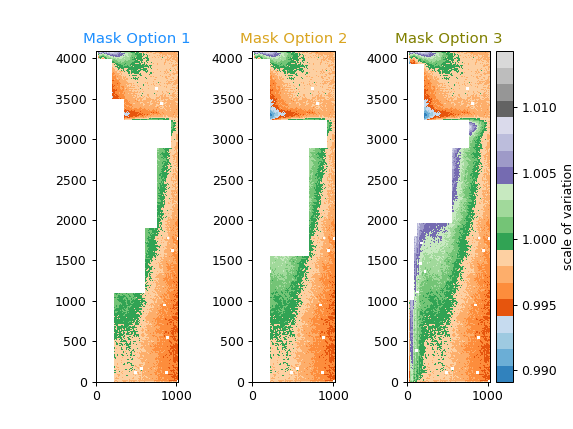

In [25]:
# Plot masked gaussian filter

plt.close('all')
fig = plt.figure()
#
# Masked left amplifier
msk_fgauss_A = np.copy(fgauss_x0[: , :1024])
msk_fgauss_A[np.where(mask_c0_A)] = np.nan
#
msk_fgauss_B = np.copy(fgauss_x0[: , :1024])
msk_fgauss_B[np.where(mask_c0_B)] = np.nan
#
msk_fgauss_C = np.copy(fgauss_x0[: , :1024])
msk_fgauss_C[np.where(mask_c0_C)] = np.nan
#
lf_min = np.min( list(map(np.nanmin, [msk_fgauss_A, msk_fgauss_B, msk_fgauss_C])) )
lf_max = np.max( list(map(np.nanmax, [msk_fgauss_A, msk_fgauss_B, msk_fgauss_C])) )
#
# 
ax0 = fig.add_subplot(1, 3, 1, aspect='equal')
#
im0 = ax0.imshow(msk_fgauss_A, 
                 cmap='tab20c', origin='lower', vmin=lf_min, vmax=lf_max)
ax0.set_title('Mask Option 1', color='dodgerblue')
#
#
ax1 = fig.add_subplot(1, 3, 2, aspect='equal')
#
im1 = ax1.imshow(msk_fgauss_B, 
                 cmap='tab20c', origin='lower', vmin=lf_min, vmax=lf_max)
ax1.set_title('Mask Option 2', color='goldenrod')
#
#
ax2 = fig.add_subplot(1, 3, 3, aspect='equal')
#
im2 = ax2.imshow(msk_fgauss_C, 
                 cmap='tab20c', origin='lower', vmin=lf_min, vmax=lf_max)
ax2.set_title('Mask Option 3', color='olive')

plt.colorbar(im0, label='scale of variation')


<IPython.core.display.Javascript object>


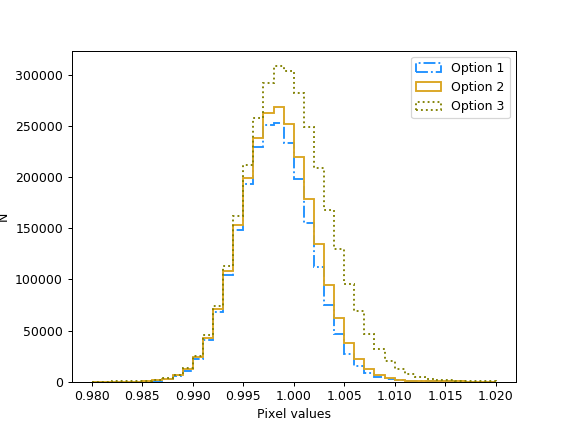

In [26]:
# Histograms for the REAL data, not after Gauss filtering
plt.close('all')
fig = plt.figure()
ax0 = fig.add_subplot(1, 1, 1)
#
aux_c0_A = np.copy(c0)[: , :1024]
aux_c0_B = np.copy(c0)[: , :1024]
aux_c0_C = np.copy(c0)[: , :1024]
#
kw_h = {'bins' : 40, 
        'range' : (0.98, 1.02),
        'cumulative' : False, 
        'histtype' : 'step',
        'lw' : 1.5,
       }
ax0.hist(aux_c0_A[~mask_c0_A], color='dodgerblue', ls='-.', label='Option 1', **kw_h)
ax0.hist(aux_c0_B[~mask_c0_B], color='goldenrod', label='Option 2', **kw_h)
ax0.hist(aux_c0_C[~mask_c0_C], color='olive', ls='dotted', label='Option 3', **kw_h)
#
ax0.set_xlabel('Pixel values')
ax0.set_ylabel('N')
plt.legend()

### KS test for 2 samples confirms different parent distributions

In [27]:
x1 = np.copy(aux_c0_A[~mask_c0_A])
x2 = np.copy(aux_c0_B[~mask_c0_B])
x1 = np.sort(x1[np.where((x1 > 0.980) & (x1 < 1.02))].ravel())
x2 = np.sort(x2[np.where((x2 > 0.980) & (x2 < 1.02))].ravel())
print('Option 1 vs 2, ', scipy.stats.ks_2samp(x1, x2))
#
x3 = np.copy(aux_c0_C[~mask_c0_C])
x3 = np.sort(x3[np.where((x3 > 0.980) & (x3 < 1.02))].ravel())
print('Option 1 vs 3, ', scipy.stats.ks_2samp(x1, x3))

Option 1 vs 2,  Ks_2sampResult(statistic=0.028815057411006539, pvalue=0.0)
Option 1 vs 3,  Ks_2sampResult(statistic=0.13094645686090578, pvalue=0.0)


### Stats description

In [28]:
print('Option 1\n========\n', scipy.stats.describe(aux_c0_A[~mask_c0_A])) #(x1)
print('\nOption 2\n========\n', scipy.stats.describe(aux_c0_B[~mask_c0_B])) #(x2)
print('\nOption 3\n========\n', scipy.stats.describe(aux_c0_C[~mask_c0_C])) #(x3)

Option 1
 DescribeResult(nobs=2215104, minmax=(-36252.477, 57633.164), mean=0.86783248, variance=2383.25, skewness=572.25927734375, kurtosis=1019756.9467192125)

Option 2
 DescribeResult(nobs=2425904, minmax=(-36252.477, 57633.164), mean=0.87937993, variance=2176.158, skewness=598.86865234375, kurtosis=1116800.1742297085)

Option 3
 DescribeResult(nobs=3170004, minmax=(-36252.477, 57633.164), mean=0.91400146, variance=1665.4475, skewness=684.5147705078125, kurtosis=1459176.0444301749)


In [ ]:
xys=[(1,2),(3,4),(6,9),(7,3)]

gxx,gyy=numpy.mgrid[0:100,0:100]
mask = numpy.where((gxx,gyy) not in set(xys)) # The bit I can't get right

In [ ]:
from scipy import sparse
xys=[(1,2),(3,4),(6,9),(7,3)]

coords = zip(*xys)
mask = sparse.coo_matrix((numpy.ones(len(coords[0])), coords ), shape= master_array.shape, dtype=bool)
draws=numpy.random.choice( master_array[~mask.toarray()].flatten(), size=10)

<IPython.core.display.Javascript object>


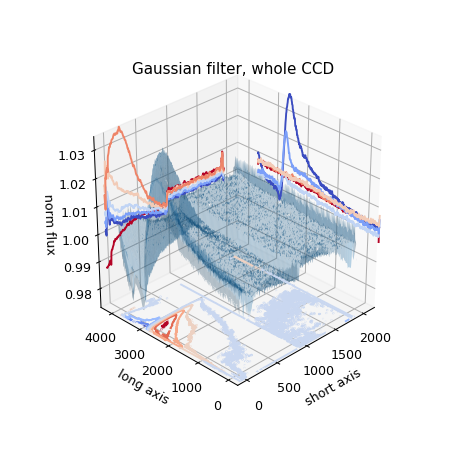

In [39]:
# Replicate above plot with its views
fgauss_d0 , fgauss_d1 = np.arange(fgauss_x0.shape[0]), np.arange(fgauss_x0.shape[1])
fgauss_d0, fgauss_d1 = np.meshgrid(fgauss_d1, fgauss_d0)

plt.close('all')
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1, projection='3d')

ax.plot_surface(fgauss_d0, fgauss_d1, fgauss_x0, rstride=40, cstride=40, alpha=0.3)
cset = ax.contour(fgauss_d0, fgauss_d1, fgauss_x0, zdir='z', offset=0.97, cmap='coolwarm')
cset = ax.contour(fgauss_d0, fgauss_d1, fgauss_x0, zdir='x', offset=2400, cmap='coolwarm')
cset = ax.contour(fgauss_d0, fgauss_d1, fgauss_x0, zdir='y', offset=4500, cmap='coolwarm')

#ax.set_zlim([guess_min, guess_max])
ax.set_xlabel('short axis')
ax.set_ylabel('long axis')
ax.set_zlabel('norm flux')
ax.set_title('Gaussian filter, whole CCD')

ax.view_init(30, -135)
# ax.view_init(16, -108)

In [ ]:
# Softening kernel
# Also :
# skimage.measure.find_contours(array, level)
# skimage.measure.approximate_polygon(coords, …)

# In a more advanced and unneccessary way:
# http://flothesof.github.io/removing-background-scikit-image.html

In [ ]:
import skimage.filters
X = np.copy(masked_c0)
X[masked_c0.mask] = np.nan
#sigma=1, output=None, mode='nearest', cval=0, multichannel=None, 
#preserve_range=False, truncate=4.0
tmp = skimage.filters.gaussian(X, sigma=2)
# experiment with different sigma for block definition
tmp = tmp[: , :1024]



# Draw blocks

plt.close('all')
plt.imshow(tmp, origin='lower')

In [ ]:
# Sobel finds the approximate derivate on a kernel of 3x3
# Dont works as expected
tmp = skimage.filters.sobel(X[:, 100:1024])
plt.close('all')
plt.imshow(tmp)

In [ ]:
# Derivate of the image
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.gradient.html

In [ ]:



#https://stackoverflow.com/questions/30079740/image-gradient-vector-field-in-python

import Image
from PIL import ImageFilter

I = Image.open('./test.png')
I = I.filter(ImageFilter.BLUR)
p = np.asarray(I).astype('int8')
w,h = I.size
x, y = np.mgrid[0:h:500j, 0:w:500j]

dy, dx = np.gradient(p)
skip = (slice(None, None, 3), slice(None, None, 3))

fig, ax = plt.subplots()
im = ax.imshow(I.transpose(Image.FLIP_TOP_BOTTOM), 
               extent=[x.min(), x.max(), y.min(), y.max()])
plt.colorbar(im)
ax.quiver(x[skip], y[skip], dx[skip].T, dy[skip].T)

ax.set(aspect=1, title='Quiver Plot')
plt.show()

In [ ]:
import scipy.ndimage
size_f = 0.0005 * 10
fourier = scipy.ndimage.fourier_uniform(X[:, :1024], size_f, n=-1, axis=-1, output=None)


lapl = scipy.ndimage.laplace(X[:, 100:1024])


plt.close('all')
plt.imshow(lapl, origin='lower')

In [ ]:
plt.close('all')
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_wireframe(bin_d0, bin_d1, aux_z, 
                  rcount=46, ccount=23, color='black',
                  lw=0.5, alpha=0.7,
                 )
ax.set_zlim([0.9, 1.1])
ax.set_zlim([guess_min, guess_max])
ax.view_init(35, 10)
#
ax.set_title('wireframe for left amplifier')
ax.set_xlabel('short axis')
ax.set_ylabel('long axis')
ax.set_zlabel('norm flux')

### Gaussian kernel? WVT? 

#### To constraint the region must first soften the surface

In [ ]:
# Useful:
# https://stackoverflow.com/questions/5666056/matplotlib-extracting-data-from-contour-lines

### After completing the softening, plot in 3D for showing wedge as surface

### Below zscale: complete it when have more available time

In [ ]:
def zscale(M, masked=False):
    ''' Try to emulate the ZSCALE algorithm from IRAF/DS9, assuming
    no mask. If mask is set, must only consider those valid points
    http://stsdas.stsci.edu/cgi-bin/gethelp.cgi?display#zscale_algorithm
    '''
    # Select a sample number of about 10% of the amount of pixels for a 
    # typical 20148x4096 CCD
    nsample = 8.4E5
    if nsample M.size
    if masked:
        # Here to construct the method for masked array
        pass
    else:
        # Distribute the number of points equally spaced in both axis
        # Define the initial grid
        x = np.arange(M.shape[1])
        y = np.arange(M.shape[0])
        xx, yy = np.meshgrid(x, y)
        print(xx)
    # If after the calculation the min/max values are the same (no contrast),
    # then use the values for teh whole image
    if (minimg == maximg):
        minimg = np.min(M)
        maximg = np.max(M)
    

In [ ]:
zscale(comp[0, :, :])

In [ ]:
'''
ZSCALE ALGORITHM
    The zscale algorithm is designed to display the  image  values  near
    the  median  image  value  without  the  time  consuming  process of
    computing a full image histogram.  This is particularly  useful  for
    astronomical  images  which  generally  have a very peaked histogram
    corresponding to  the  background  sky  in  direct  imaging  or  the
    continuum in a two dimensional spectrum.
    The  sample  of pixels, specified by values greater than zero in the
    sample mask zmask or by an  image  section,  is  selected  up  to  a
    maximum  of nsample pixels.  If a bad pixel mask is specified by the
    bpmask parameter then any pixels with mask values which are  greater
    than  zero  are not counted in the sample.  Only the first pixels up
    to the limit are selected where the order is by line beginning  from
    the  first line.  If no mask is specified then a grid of pixels with
    even spacing along lines and columns that  make  up  a  number  less
    than or equal to the maximum sample size is used.
    If  a  contrast of zero is specified (or the zrange flag is used and
    the image does not have a  valid  minimum/maximum  value)  then  the
    minimum  and maximum of the sample is used for the intensity mapping
    range.
    If the contrast  is  not  zero  the  sample  pixels  are  ranked  in
    brightness  to  form  the  function  I(i) where i is the rank of the
    pixel and I is its value.  Generally the midpoint of  this  function
    (the  median) is very near the peak of the image histogram and there
    is a well defined slope about the midpoint which is related  to  the
    width  of the histogram.  At the ends of the I(i) function there are
    a few very bright and dark pixels due to objects and defects in  the
    field.   To  determine  the  slope  a  linear  function  is fit with
    iterative rejection;
            I(i) = intercept + slope * (i - midpoint)
    If more than half of the points are rejected then there is  no  well
    defined  slope  and  the full range of the sample defines z1 and z2.
    Otherwise the endpoints of the linear function  are  used  (provided
    they are within the original range of the sample):
            z1 = I(midpoint) + (slope / contrast) * (1 - midpoint)
            z2 = I(midpoint) + (slope / contrast) * (npoints - midpoint)
    As  can  be  seen,  the parameter contrast may be used to adjust the
    contrast produced by this algorithm.
'''